# PINNs-Based 1D Acoustic Wave Simulation with a Source Term

This notebook presents a neural network aproximation reinforced with PINNs to the solution for the homogeneous 1D elastic wave equation

\begin{equation}
\rho \partial_t^2 u(x,t) =  \mu\partial_x^2 u(x,t) + f(x,t),
\end{equation}


where:

- $ \rho $ is the constant density of the medium (in kg/m³).
- $ u(x,t) $ (in m) is the displacement field, which depends on position $ x $ (in m) and time $ t $ (in s).
- $ \partial_t^2 $ is the second derivative with respect to time, representing acceleration (in 1/s²).
- $ \mu $ is the constant shear modulus, which measures the material's resistance to shear stress (in Pa or N/m² or kg/(m·s²)).
- $ \partial_x^2 $ is the second derivative with respect to position $ x $ (in 1/m²).
- $ f(x,t) $ is the external force applied, which depends on position $ x $ (in m) and time $ t $ (in s), and has units of force density (in N/m³ or kg/(m²s²)).


In the following code block, we import the necessary libraries for our notebook. This includes NumPy for numerical operations, PyTorch for building and training the neural network, Matplotlib for plotting, a utility module for additional plotting functions, and the time module for timing our training process.

In [1]:
# Import libraries for numerical operations
import numpy as np

# Import libraries for random operations and data serialization
import random
import pickle

# Import PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim

# Import libraries for data visualization
import matplotlib.pyplot as plt
from utils_plots import *  # utility module for additional plotting functions

# Import libraries for utility functions
import time  # to time our training process
from scipy.interpolate import griddata  # for data interpolation

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configure warnings
import warnings
warnings.filterwarnings("ignore")  # Ignore warning messages

In the following code block, we load the data obteined from a spectral elements implemented in the notebook W9_se_homo_1d_solution.ipynb with modified input parameters of the course [computers, waves, simulations](https://www.coursera.org/learn/computers-waves-simulations).

The following parameters were chosen for the simulation:

- A density ($\rho$) of 2200 kg/m³.
- The shear modulus, denoted by $\mu$, calculated as the product of density ($\rho$ = 2200 kg/m³) and the square of the S-wave velocity ($v_{s}$ = 2500 m/s), resulting in 13.75 $\times 10^{9}$ kg/(m·s²).
- The $x$ domain is set to [0, 1000] (m).
- The $t$ domain is set to [0, 0.15] (s).

The result of the simulation is loaded  in the following cell. Where `t_grid` contain the $t$ domain values, `x_grid` the $x$ domain values and `u_grid` the displacement field.

In [2]:
# Open the file containing the data
with open('traditional_homogeneous_1D/data/4_se_data.pkl', 'rb') as f:
    # Load the data from the file
    # t_grid, x_grid, and u_grid are expected to be in the file
    t_grid, x_grid, u_grid = pickle.load(f)

# Convert the loaded data to NumPy arrays for easier manipulation
# This step is necessary if the loaded data is not already in NumPy array format
x_grid = np.array(x_grid)  # Grid of x values
t_grid = np.array(t_grid)  # Grid of t (time) values
u_grid = np.array(u_grid)  # Grid of u (wave amplitude) values

This cell generates a new grid of 10,000 points, arranged in a 100x100 matrix, by interpolating the original `x_grid`, `t_grid`, and `u_grid` values using a 'linear' method. In this grid, `x` represents the horizontal axis and `t` represents the vertical axis. This preprocessing of the data is performed to reduce the time required for neural network training.

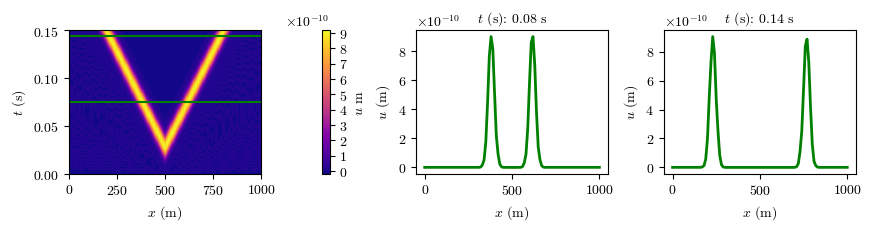

In [3]:
# Define the number of points for the new grid
num_points = 101

# Create a new grid of points
# The range of the grid is determined by the minimum and maximum values of the original grids
x_new = np.linspace(np.min(x_grid), np.max(x_grid), num_points)
t_new = np.linspace(np.min(t_grid), np.max(t_grid), num_points)

# Create a meshgrid using the new x and t values
x_grid_new, t_grid_new = np.meshgrid(x_new, t_new)

# Prepare the data for interpolation
# The original x and t grids are flattened and stacked vertically
# The u_grid is also flattened to match the shape
points = np.vstack((x_grid.flatten(), t_grid.flatten())).T
values = u_grid.flatten()

# Perform the interpolation using the 'nearest' method
u_grid_new = griddata(points, values, (x_grid_new, t_grid_new), method='nearest')

# Identify the NaN values in the interpolated data
mask = np.isnan(u_grid_new)

# Replace the NaN values with the nearest non-NaN values
u_grid_new[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), u_grid_new[~mask])

# Update the original grids with the new grids
x_grid = x_grid_new
t_grid = t_grid_new
u_grid = u_grid_new

fig, axs = plt.subplots(1, 3, figsize=(8.6, 2.2))

# First subplot
contourf_plot=axs[0].contourf(x_grid, t_grid, u_grid, origin='lower', extent=(0, 1, 0, 1), levels=50,cmap='plasma')
axs[0].set_xlabel('$x$ (m)')
axs[0].set_ylabel('$t$ (s)')
axs[0].axhline(np.max(t_grid)/2, color='green')
axs[0].axhline(t_grid[-5,0], color='green')
fig.colorbar(contourf_plot, ax=axs[0], label='$u$ m')

# Second subplot
axs[1].plot(x_grid[int(x_grid.shape[0]*0.5),:], u_grid[int(x_grid.shape[0]*0.5),:], color='green', linewidth=2)
axs[1].set_xlabel('$x$ (m)')
axs[1].set_ylabel('$u$ (m)')
axs[1].set_title("$t$ (s): {:.2f} s".format(t_grid[int(x_grid.shape[0]*0.5),0]),fontsize=10)

# Third subplot
axs[2].plot(x_grid[int(x_grid.shape[0]*0.9),:], u_grid[int(x_grid.shape[0]*0.9),:], color='green', linewidth=2)
axs[2].set_xlabel('$x$ (m)')
axs[2].set_ylabel('$u$ (m)')
axs[2].set_title("$t$ (s): {:.2f} s".format(t_grid[int(x_grid.shape[0]*0.9),0]),fontsize=10)

plt.show()

This following source function variable for the simulated acoustic wave, creates a grid for the source amplitude, sets the source amplitude at the center of the grid for all time using the defined source function, and then plots a contour graph of the source amplitude over the grid.

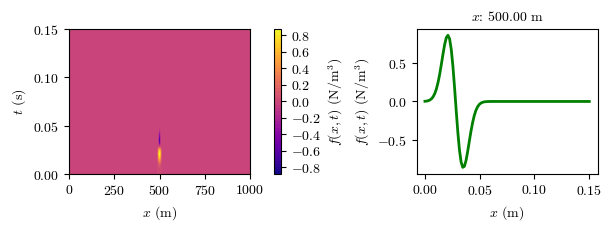

In [4]:
# Define source parameters
f0 = 25.  # Dominant frequency of the source (Hz)
t0 = 0.7 / f0  # Source time shift

# Define the source function
def src(t):
    """Calculate the source amplitude at a given time."""
    return -8. * (t - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (t - t0) ** 2))

# Create a grid for the source amplitude
# Dimensions are derived from t_grid and x_grid
f_grid = np.zeros((len(t_grid[:,0]), len(x_grid[1])))

# Set the source amplitude at x=max(x_grid)/2 for all t
# Using the defined source function
f_grid[:, int(len(x_grid[1])/2)] = src(t_new) 

fig, axs = plt.subplots(1, 2, figsize=(6.0, 2.2))

# First subplot
contourf_plot=axs[0].contourf(x_grid, t_grid, f_grid, origin='lower', extent=(0, 1, 0, 1), levels=50,cmap='plasma')
axs[0].set_xlabel('$x$ (m)')
axs[0].set_ylabel('$t$ (s)')
#axs[0].axvline(t_grid[:,int(len(x_grid[1])/2)], color='green')
fig.colorbar(contourf_plot, ax=axs[0], label='$f(x,t)$ (N/m$^{3}$)')

# Second subplot
axs[1].plot(t_grid[:,0], f_grid[:,int(len(x_grid[1])/2)], color='green', linewidth=2)
axs[1].set_xlabel('$x$ (m)')
axs[1].set_ylabel('$f(x,t)$ (N/m$^{3}$)')
axs[1].set_title("$x$: {:.2f} m".format(x_grid[0,int(len(x_grid[1])/2)]),fontsize=10)

plt.show()

## Variable Scaling and Non-Dimensionalization

To scale the independent variables ($x$ and $t$) and dependent variables ($u$ and $f$) in equation 1, we need to introduce non-dimensional variables. We denote the characteristic length scale as L (which could be, for instance, the maximum length in the problem), the characteristic time scale as T (such as the maximum time in the problem), and the characteristic displacement and force as $U$ and $F$ respectively.

We define the non-dimensional variables as follows:

- $ x' = \frac{x}{L} $

- $ t' = \frac{t}{T} $

- $ u' = \frac{u}{U} $

- $ f' = \frac{f}{F} $

Substituting these into the equation 1 yields:

\begin{equation}\tag{2} \rho \frac{U}{T^2} \frac{\partial^2 u'}{\partial {t'}^2} = \mu \frac{U}{L^2} \frac{\partial^2 u'}{\partial {x'}^2} + F f'(x',t'). \end{equation}

This results in an equation where all variables have been non-dimensionalized. To simplify, we can define new parameters as follows:

- $\rho' = \rho \frac{U}{F T^2}$

- $\mu' = \mu \frac{U}{ F L^2}$

Substituting these into the equation 2, we get:

\begin{equation}\tag{3}
\rho'\frac{\partial^2 u'}{\partial {t'}^2} = \mu' \frac{\partial^2 u'}{\partial {x'}^2} +  f'(x',t').
\end{equation}

For the simulation considered in this notebook let's consider:

- $\mu$ = 2500 m/s
- $\rho$ = 2200 kg/m³
- U = 9.08 $\times 10^{-9}$ m
- T = 0.15 s
- L = 1000 m
- F = 0.85 N/m³

In [5]:
vs = 2500 # S velocity [m/s] 
rho = 2200 # Density [kg/m^3]
mu = rho * vs**2 # Shear modulus mu
U = np.max(u_grid) # max u [m]
T = np.max(t_grid) # max t [s]
L = np.max(x_grid) # maximun x [m]
F = np.max(f_grid) # max f [N/m^3]
rho_prime = rho * U / (F*T**2) # [kg/m^2]
mu_prime = mu * U / (F*L**2) # [s^2/kg]

In the following cell we obtain $x'$(`x_prime`), $t'$(`t_prime`), $u'$(`u_prime`) and $f'$(`f_prime`) from $x$(`x_grid`), $y$(`y_grid`), $u$(`u_grid`) and $f$(`f_grid`). 

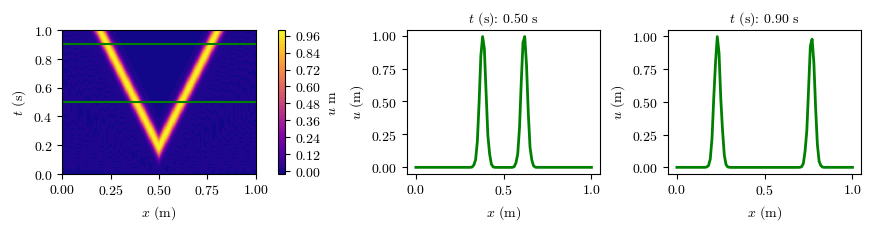

In [6]:
# Normalize x_grid by the length L to get dimensionless spatial coordinates
x_prime = x_grid / L

# Normalize t_grid by the time T to get dimensionless time coordinates
t_prime = t_grid / T

# Normalize u_grid by the velocity U to get dimensionless velocity
u_prime = u_grid / U

# Normalize f_grid by the force F to get dimensionless force
f_prime = f_grid / F

fig, axs = plt.subplots(1, 3, figsize=(8.6, 2.2))

# First subplot
contourf_plot=axs[0].contourf(x_prime, t_prime, u_prime, origin='lower', extent=(0, 1, 0, 1), levels=50,cmap='plasma')
axs[0].set_xlabel('$x$ (m)')
axs[0].set_ylabel('$t$ (s)')
axs[0].axhline(t_prime[int(x_prime.shape[0]*0.5),0], color='green')
axs[0].axhline(t_prime[int(x_prime.shape[0]*0.9),0], color='green')
fig.colorbar(contourf_plot, ax=axs[0], label='$u$ m')

# Second subplot
axs[1].plot(x_prime[int(x_prime.shape[0]*0.5),:], u_prime[int(x_prime.shape[0]*0.5),:], color='green', linewidth=2)
axs[1].set_xlabel('$x$ (m)')
axs[1].set_ylabel('$u$ (m)')
axs[1].set_title("$t$ (s): {:.2f} s".format(t_prime[int(x_prime.shape[0]*0.5),0]),fontsize=10)

# Third subplot
axs[2].plot(x_prime[int(x_prime.shape[0]*0.9),:], u_prime[int(x_prime.shape[0]*0.9),:], color='green', linewidth=2)
axs[2].set_xlabel('$x$ (m)')
axs[2].set_ylabel('$u$ (m)')
axs[2].set_title("$t$ (s): {:.2f} s".format(t_prime[int(x_prime.shape[0]*0.9),0]),fontsize=10)

plt.show()

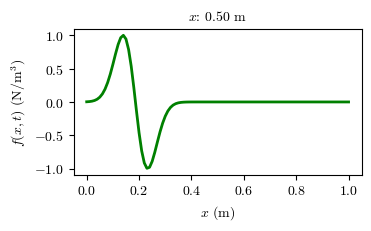

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(3.6, 2.2))

# Plot
axs.plot(t_prime[:,0], f_prime[:,int(len(x_prime[1])/2)], color='green', linewidth=2)
axs.set_xlabel('$x$ (m)')
axs.set_ylabel('$f(x,t)$ (N/m$^{3}$)')
axs.set_title("$x$: {:.2f} m".format(x_prime[0,int(len(x_grid[1])/2)]),fontsize=10)

plt.show()

This cell converts the numpy arrays to PyTorch tensors.

In [8]:
# Convert the normalized spatial coordinates to a PyTorch tensor, ensure it's a float, add an extra dimension, and enable gradient computation
x_tensor = torch.from_numpy(x_prime).float().unsqueeze(-1).requires_grad_(True)

# Convert the normalized time coordinates to a PyTorch tensor, ensure it's a float, add an extra dimension, and enable gradient computation
t_tensor = torch.from_numpy(t_prime).float().unsqueeze(-1).requires_grad_(True)

# Convert the normalized velocity to a PyTorch tensor, ensure it's a float, and add an extra dimension
u_tensor = torch.from_numpy(u_prime).float().unsqueeze(-1)

# Convert the normalized force to a PyTorch tensor, ensure it's a float, and add an extra dimension
f_tensor = torch.from_numpy(f_prime).float().unsqueeze(-1)

This cell defines a neural network with three fully connected layers, creates an instance of this network, and sets up the Adam optimizer and Mean Squared Error loss function for training the network.

In [54]:
# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 10)
        self.layer3 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        x = self.output_layer(x)
        return x

# Create an instance of the neural network
neural_net = NeuralNetwork()

# Define the learning rate
learning_rate = 0.01

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(neural_net.parameters(), lr=learning_rate)

# Define a loss function (Mean Squared Error) for training the network
criterion = nn.MSELoss()

This cell creates the input data by concatenating normalized `x` and `t` grid tensors, defines the output data, and selects a subset for training. The subset consists of the first third of the `t` coordinate and the entire `x` coordinate, chosen using random indices.

This cell trains the neural network, tracks the loss over iterations, calculates the training time, and writes a summary of the training process to a text file.

In [55]:
# Concatenate x and t tensors to form the input data
inputs = torch.cat((x_tensor, t_tensor), dim=-1)  # x_tensor.shape = torch.Size([201, 201, 1]) and  t_tensor.shape = torch.Size([201, 201, 1])

# Define the output data
outputs = u_tensor # u_tensor.shape = torch.Size([201, 201, 1])

# Define the dataset
dataset = TensorDataset(inputs, outputs)

# Define the data loader
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define number of epochs
num_epochs = 200

# List to store losses
losses = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in data_loader:
        optimizer.zero_grad()
        outputs = neural_net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(data_loader)
    losses.append(epoch_loss)
    
    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

print('Finished Training')

Epoch 100/200, Loss: 0.03411287348717451
Epoch 200/200, Loss: 0.01317634154111147
Finished Training


In [56]:
inputs = torch.cat((x_tensor, t_tensor), dim=-1)  # x_tensor.shape = torch.Size([201, 201, 1]) and  t_tensor.shape = torch.Size([201, 201, 1])

u_pred = neural_net(inputs).detach().numpy().reshape(x_prime.shape)
# Assume u_true is the true values
u_true = u_prime

mse = mean_squared_error(u_true, u_pred)
 
mae = mean_absolute_error(u_true, u_pred)
 
print(f"Prediction 1: MSE = {mse}, MAE = {mae}")

Prediction 1: MSE = 0.013232295648053788, MAE = 0.05303633827740598


In [57]:
# Save the trained model's parameters to a file
torch.save(neural_net.state_dict(), 'models/5_1D_Wave_Source_PINNs.pth')

# Initialize a new instance of the neural network
neural_net = NeuralNetwork()

# Load the saved parameters into the new instance of the neural network
neural_net.load_state_dict(torch.load('models/5_1D_Wave_Source_PINNs.pth'))

# Ensure the new neural network is in evaluation mode
neural_net.eval()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

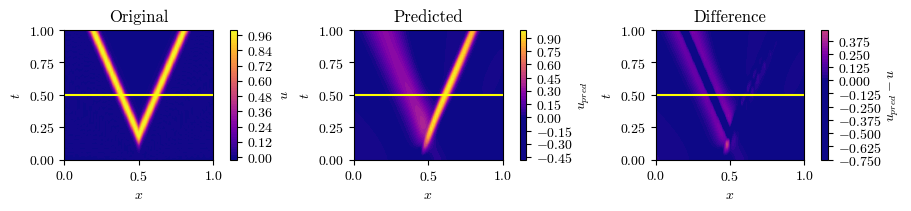

In [58]:
# Concatenate x and t tensors to form the input data
input_data = torch.cat((x_tensor, t_tensor), dim=-1)
# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net(input_data).detach().numpy().reshape(x_prime.shape)

# Rescale u_pred
u_pred = u_pred #* np.max(u_prime)  

# Define a function to plot a contour graph
def plot_contour(ax, x, t, u, title, label):
    im = ax.contourf(x, t, u, origin='lower', levels=50, cmap='plasma', vmin=0, vmax=1) 
    ax.set_title(title)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    fig.colorbar(im, ax=ax, label=label)
    # Draw a horizontal line at t=np.max(t_grid)/2
    ax.axhline(y=np.max(t)*0.5, color='yellow')


# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Plot the original u values
plot_contour(axs[0], x_prime, t_prime, u_prime, 'Original', '$u$')

# Plot the predicted u values
plot_contour(axs[1], x_prime, t_prime, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], x_prime, t_prime, u_pred-u_prime, 'Difference', '$u_{pred}-u$')

# Uncomment the following line to save the plot as a PNG file in the 'imgs' directory
fig.savefig('imgs/5_Predicted_and_Difference_1D_Wave_Source_PINNs.png', format='png')

# Display the plot
plt.show()

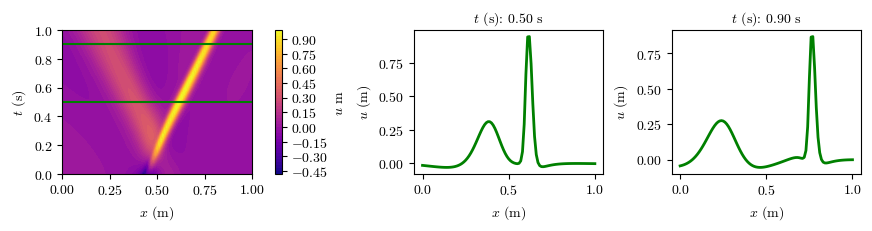

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(8.6, 2.2))

# First subplot
contourf_plot=axs[0].contourf(x_prime, t_prime, u_pred, origin='lower', extent=(0, 1, 0, 1), levels=50,cmap='plasma')
axs[0].set_xlabel('$x$ (m)')
axs[0].set_ylabel('$t$ (s)')
axs[0].axhline(t_prime[int(x_prime.shape[0]*0.5),0], color='green')
axs[0].axhline(t_prime[int(x_prime.shape[0]*0.9),0], color='green')
fig.colorbar(contourf_plot, ax=axs[0], label='$u$ m')

# Second subplot
axs[1].plot(x_prime[int(x_prime.shape[0]*0.5),:], u_pred[int(x_prime.shape[0]*0.5),:], color='green', linewidth=2)
axs[1].set_xlabel('$x$ (m)')
axs[1].set_ylabel('$u$ (m)')
axs[1].set_title("$t$ (s): {:.2f} s".format(t_prime[int(x_prime.shape[0]*0.5),0]),fontsize=10)

# Third subplot
axs[2].plot(x_prime[int(x_prime.shape[0]*0.9),:], u_pred[int(x_prime.shape[0]*0.9),:], color='green', linewidth=2)
axs[2].set_xlabel('$x$ (m)')
axs[2].set_ylabel('$u$ (m)')
axs[2].set_title("$t$ (s): {:.2f} s".format(t_prime[int(x_prime.shape[0]*0.9),0]),fontsize=10)

plt.show()

In [27]:
# # Define a neural network class with three fully connected layers
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         # Define the layers
#         self.layer1 = nn.Linear(2, 10)
#         self.layer2 = nn.Linear(10, 10)
#         self.layer3 = nn.Linear(10, 10)
#         self.output_layer = nn.Linear(10, 1)

#     def forward(self, x):
#         # Define the forward pass
#         x = torch.tanh(self.layer1(x))
#         x = torch.tanh(self.layer2(x))
#         x = torch.tanh(self.layer3(x))
#         x = self.output_layer(x)
#         return x

# # Create an instance of the neural network
# neural_net = NeuralNetwork()

# # Define the learning rate
# learning_rate = 0.01

# # Define an optimizer (Adam) for training the network
# optimizer = optim.Adam(neural_net.parameters(), lr=learning_rate)

# # Define a loss function (Mean Squared Error) for training the network
# criterion = nn.MSELoss()

In [62]:
# Concatenate x and t tensors to form the input data
inputs = torch.cat((x_tensor, t_tensor), dim=-1)  # x_tensor.shape = torch.Size([201, 201, 1]) and  t_tensor.shape = torch.Size([201, 201, 1])#
outputs = u_tensor
# Define the dataset
#dataset = TensorDataset(inputs, outputs)

# Define the data loader
#batch_size = 32
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define number of epochs
num_epochs = 5000

# List to store losses
losses = []

#w_d = 1
w_p =1e+3

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    #for inputs, targets in data_loader:
    optimizer.zero_grad()
    outputs_ = neural_net(inputs)
    #outputs_ = neural_net(inputs_physics)
    dudx  = torch.autograd.grad(outputs_, x_tensor, torch.ones_like(outputs_), create_graph=True)[0] # computes du/dx
    dudx2 = torch.autograd.grad(dudx,  x_tensor, torch.ones_like(dudx),  create_graph=True)[0] # computes d^2u/dx^2
    dudt  = torch.autograd.grad(outputs_, t_tensor, torch.ones_like(outputs_), create_graph=True)[0] # computes du/dt
    dudt2 = torch.autograd.grad(dudt,  t_tensor, torch.ones_like(dudt),  create_graph=True)[0] # computes d^2u/dt^2
    physics =  rho_prime*dudt2 - mu_prime*dudx2 - f_tensor
    #data_loss = criterion(outputs, targets)
    physics_loss = torch.mean(physics**2)
    loss = w_p*physics_loss#w_p*physics_loss#w_p*physics_loss + w_d*data_loss
    loss.backward(retain_graph=True)#retain_graph=True
    optimizer.step()
    running_loss += loss.item()
    
    epoch_loss = running_loss / len(data_loader)
    losses.append(epoch_loss)
    
    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

print('Finished Training')

Epoch 100/5000, Loss: 0.2704133689403534
Epoch 200/5000, Loss: 0.2704133689403534
Epoch 300/5000, Loss: 0.2704133689403534
Epoch 400/5000, Loss: 0.2704133689403534
Epoch 500/5000, Loss: 0.2704133689403534
Epoch 600/5000, Loss: 0.2704133689403534
Epoch 700/5000, Loss: 0.2704133689403534
Epoch 800/5000, Loss: 0.2704133689403534
Epoch 900/5000, Loss: 0.2704133689403534
Epoch 1000/5000, Loss: 0.2704133689403534
Epoch 1100/5000, Loss: 0.2704133689403534
Epoch 1200/5000, Loss: 0.2704133689403534
Epoch 1300/5000, Loss: 0.2704133689403534
Epoch 1400/5000, Loss: 0.2704133689403534
Epoch 1500/5000, Loss: 0.2704133689403534
Epoch 1600/5000, Loss: 0.2704133689403534
Epoch 1700/5000, Loss: 0.2704133689403534
Epoch 1800/5000, Loss: 0.2704133689403534
Epoch 1900/5000, Loss: 0.2704133689403534
Epoch 2000/5000, Loss: 0.2704133689403534
Epoch 2100/5000, Loss: 0.2704133689403534
Epoch 2200/5000, Loss: 0.2704133689403534
Epoch 2300/5000, Loss: 0.2704133689403534
Epoch 2400/5000, Loss: 0.2704133689403534
E

In [38]:
inputs = torch.cat((x_tensor, t_tensor), dim=-1)  # x_tensor.shape = torch.Size([201, 201, 1]) and  t_tensor.shape = torch.Size([201, 201, 1])

u_pred = neural_net(inputs).detach().numpy().reshape(x_prime.shape)
# Assume u_true is the true values
u_true = u_prime

mse = mean_squared_error(u_true, u_pred)
 
mae = mean_absolute_error(u_true, u_pred)
 
print(f"Prediction: MSE = {mse}, MAE = {mae}")

Prediction: MSE = 0.00021721771802795512, MAE = 0.0065200142645457865


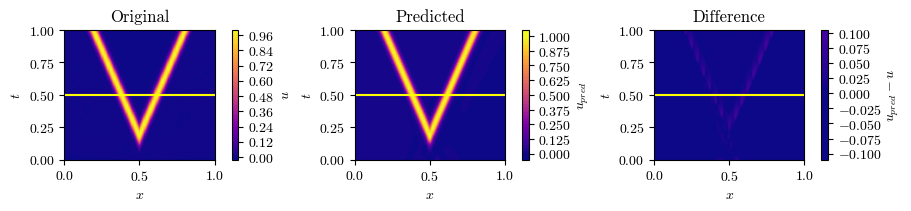

In [39]:
# Concatenate x and t tensors to form the input data
input_data = torch.cat((x_tensor, t_tensor), dim=-1)
# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net(input_data).detach().numpy().reshape(x_prime.shape)

# Rescale u_pred
u_pred = u_pred #* np.max(u_prime)  

# Define a function to plot a contour graph
def plot_contour(ax, x, t, u, title, label):
    im = ax.contourf(x, t, u, origin='lower', levels=50, cmap='plasma', vmin=0, vmax=1) 
    ax.set_title(title)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    fig.colorbar(im, ax=ax, label=label)
    # Draw a horizontal line at t=np.max(t_grid)/2
    ax.axhline(y=np.max(t)*0.5, color='yellow')


# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Plot the original u values
plot_contour(axs[0], x_prime, t_prime, u_prime, 'Original', '$u$')

# Plot the predicted u values
plot_contour(axs[1], x_prime, t_prime, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], x_prime, t_prime, u_pred-u_prime, 'Difference', '$u_{pred}-u$')

# Uncomment the following line to save the plot as a PNG file in the 'imgs' directory
fig.savefig('imgs/5_Predicted_and_Difference_1D_Wave_Source_PINNs.png', format='png')

# Display the plot
plt.show()

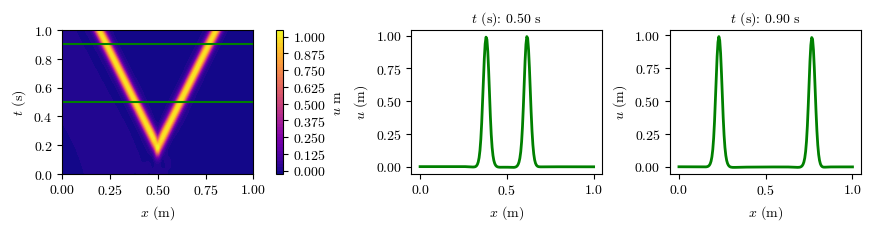

In [107]:
fig, axs = plt.subplots(1, 3, figsize=(8.6, 2.2))

# First subplot
contourf_plot=axs[0].contourf(x_prime, t_prime, u_pred, origin='lower', extent=(0, 1, 0, 1), levels=50,cmap='plasma')
axs[0].set_xlabel('$x$ (m)')
axs[0].set_ylabel('$t$ (s)')
axs[0].axhline(t_prime[int(x_prime.shape[0]*0.5),0], color='green')
axs[0].axhline(t_prime[int(x_prime.shape[0]*0.9),0], color='green')
fig.colorbar(contourf_plot, ax=axs[0], label='$u$ m')

# Second subplot
axs[1].plot(x_prime[int(x_prime.shape[0]*0.5),:], u_pred[int(x_prime.shape[0]*0.5),:], color='green', linewidth=2)
axs[1].set_xlabel('$x$ (m)')
axs[1].set_ylabel('$u$ (m)')
axs[1].set_title("$t$ (s): {:.2f} s".format(t_prime[int(x_prime.shape[0]*0.5),0]),fontsize=10)

# Third subplot
axs[2].plot(x_prime[int(x_prime.shape[0]*0.9),:], u_pred[int(x_prime.shape[0]*0.9),:], color='green', linewidth=2)
axs[2].set_xlabel('$x$ (m)')
axs[2].set_ylabel('$u$ (m)')
axs[2].set_title("$t$ (s): {:.2f} s".format(t_prime[int(x_prime.shape[0]*0.9),0]),fontsize=10)

plt.show()

In [15]:
# Predictions for data conditions
prediction_data = neural_net_2(selected_data)
data_loss = loss_func(prediction_data, output_data_2)

# Predictions for physics conditions
prediction_physics_loss = neural_net_2(input_data)
 
# Compute derivatives of prediction with respect to x and t
dudx  = torch.autograd.grad(prediction_physics_loss, x_tensor, torch.ones_like(prediction_physics_loss), create_graph=True)[0] # computes du/dx
dudx2 = torch.autograd.grad(dudx,  x_tensor, torch.ones_like(dudx),  create_graph=True)[0] # computes d^2u/dx^2
dudt  = torch.autograd.grad(prediction_physics_loss, t_tensor, torch.ones_like(prediction_physics_loss), create_graph=True)[0] # computes du/dt
dudt2 = torch.autograd.grad(dudt,  t_tensor, torch.ones_like(dudt),  create_graph=True)[0] # computes d^2u/dt^2

# Compute physics condition
physics =  rho_prime*dudt2 - mu_prime*dudx2 - f_tensor 

# Compute loss for physics condition
physics_loss = torch.mean(physics**2)

# Calculate the loss
# Total loss is the sum of boundary and physics loss
loss = data_loss + physics_loss
physics_loss_init = physics_loss.detach()
data_loss_init=data_loss.detach()

print(data_loss_init)
print(physics_loss_init)

tensor(0.0635)
tensor(0.0011)


In [16]:
# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Define the number of training iterations
num_iterations = 20_001

w_data = 1#-1e-6
w_phyisics = 1e-6
# Train the neural network
for i in range(num_iterations):


    # Make a prediction based on the input data
    prediction_data = neural_net_2(selected_data)
    data_loss = loss_func(prediction_data, output_data_2)
    data_loss = w_data*(data_loss/data_loss_init)
    
    # Predictions for physics conditions
    prediction_physics_loss = neural_net_2(input_data)

    # Compute derivatives of prediction with respect to x and t
    dudx  = torch.autograd.grad(prediction_physics_loss, x_tensor, torch.ones_like(prediction_physics_loss), create_graph=True)[0] # computes du/dx
    dudx2 = torch.autograd.grad(dudx,  x_tensor, torch.ones_like(dudx),  create_graph=True)[0] # computes d^2u/dx^2
    dudt  = torch.autograd.grad(prediction_physics_loss, t_tensor, torch.ones_like(prediction_physics_loss), create_graph=True)[0] # computes du/dt
    dudt2 = torch.autograd.grad(dudt,  t_tensor, torch.ones_like(dudt),  create_graph=True)[0] # computes d^2u/dt^2

    # Compute physics condition
    physics =  rho_prime*dudt2 - mu_prime*dudx2 - f_tensor 
 

    # Compute loss for physics condition
    physics_loss = torch.mean(physics**2)
    physics_loss = w_phyisics*(physics_loss/physics_loss_init)
     
    #print('data_loss:',data_loss)
    #print('physics_loss:',physics_loss)
    # Calculate the loss
    # Total loss is the sum of boundary and physics loss
    loss = data_loss + physics_loss
    
    # Append the current loss value to the list    
    loss_values.append(loss.item())
    
    # Print the loss every 1000 iterations
    if i % 1000 == 0:
        print(f"Iteration {i}: Loss {loss.item()}")
    
    # Clear gradients for the next training iteration
    optimizer.zero_grad()
    
    # Perform backpropagation and compute gradients
    loss.backward(retain_graph=True)
    
    # Update the weights
    optimizer.step()
  
# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Define the summary file path
summary_file_path = "summaries/5_2_1D_Wave_Source_PINNs.txt"

# Save a summary of the training process to a text file
with open(summary_file_path, "w") as file:
    file.write("Summary of Neural Network Training\n")
    file.write("=================================\n\n")
    file.write(f"Neural Network Architecture:\n{neural_net}\n\n")
    file.write(f"Optimizer Used:\n{type(optimizer).__name__}\n\n")
    file.write(f"Learning Rate:\n{optimizer.param_groups[0]['lr']}\n\n")
    file.write(f"Number of Iterations:\n{len(loss_values)}\n\n")
    file.write(f"Initial Loss:\n{loss_values[0]}\n\n")
    # Calculate the average loss
    average_loss = sum(loss_values) / len(loss_values)
    file.write(f"Average Loss:\n{average_loss}\n\n")
    # Find the iteration with the minimum loss
    min_loss_value = min(loss_values)
    min_loss_iteration = loss_values.index(min_loss_value)
    file.write(f"Minimum Loss:\n{min_loss_value} at iteration {min_loss_iteration}\n\n")    
    file.write(f"Final Loss:\n{loss_values[-1]}\n\n")
    file.write(f"Training Time:\n{elapsed_time} seconds\n\n")    

Iteration 0: Loss 1.0000009536743164
Iteration 1000: Loss 0.0027078434359282255
Iteration 2000: Loss 0.0018004016019403934
Iteration 3000: Loss 0.0009854314848780632
Iteration 4000: Loss 0.0006727123982273042
Iteration 5000: Loss 0.0005541463033296168
Iteration 6000: Loss 0.0004974054754711688
Iteration 7000: Loss 0.0005153684760443866
Iteration 8000: Loss 0.0004963981918990612
Iteration 9000: Loss 0.0004383721388876438
Iteration 10000: Loss 0.0004223543219268322
Iteration 11000: Loss 0.0004224591248203069
Iteration 12000: Loss 0.00040487016667611897
Iteration 13000: Loss 0.0012362762354314327
Iteration 14000: Loss 0.0004247801552992314
Iteration 15000: Loss 0.00039615726564079523
Iteration 16000: Loss 0.00038960209349170327
Iteration 17000: Loss 0.0003868723870255053
Iteration 18000: Loss 0.00038305623456835747
Iteration 19000: Loss 0.0004347172798588872
Iteration 20000: Loss 0.0003831377252936363
Training time: 857.8627691268921 seconds


In [17]:
print(f"Iteration {i}: Loss {loss.item()}")

Iteration 20000: Loss 0.0003831377252936363


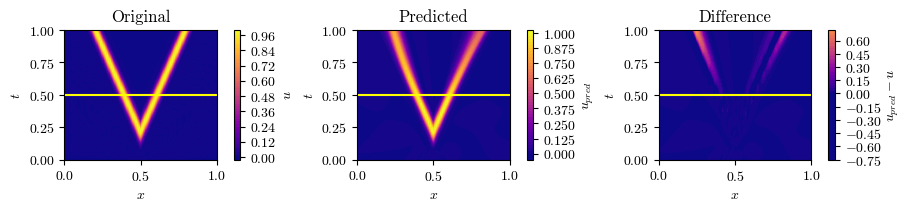

In [18]:
# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net_2(input_data).detach().numpy().reshape(x_prime.shape)

# Rescale u_pred
u_pred = u_pred #* np.max(u_prime)  

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower', levels=50, cmap='plasma', vmax=np.max(u_prime), vmin=np.min(u_prime)) 
    ax.set_title(title)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    fig.colorbar(im, ax=ax, label=label)
    # Draw a horizontal line at t=np.max(t_grid)/2
    ax.axhline(y=np.max(t_prime)*0.5, color='yellow')
    
    

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Plot the original u values
plot_contour(axs[0], x_prime, t_prime, u_prime, 'Original', '$u$')

# Plot the predicted u values
plot_contour(axs[1], x_prime, t_prime, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], x_prime, t_prime, u_pred-u_prime, 'Difference', '$u_{pred}-u$')

# Uncomment the following line to save the plot as a PNG file in the 'imgs' directory
fig.savefig('imgs/5_Predicted_and_Difference_1D_Wave_Source_PINNs.png', format='png')

# Display the plot
plt.show()

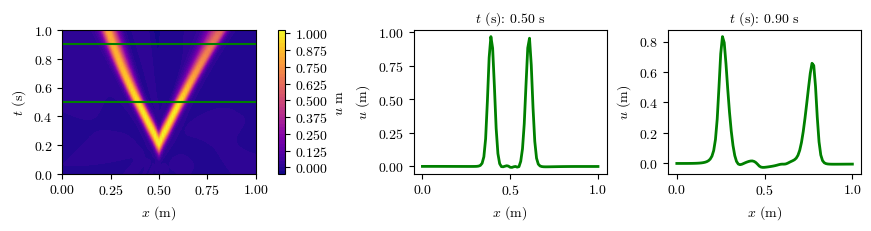

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(8.6, 2.2))

# First subplot
contourf_plot=axs[0].contourf(x_prime, t_prime, u_pred, origin='lower', extent=(0, 1, 0, 1), levels=50,cmap='plasma')
axs[0].set_xlabel('$x$ (m)')
axs[0].set_ylabel('$t$ (s)')
axs[0].axhline(t_prime[int(x_prime.shape[0]*0.5),0], color='green')
axs[0].axhline(t_prime[int(x_prime.shape[0]*0.9),0], color='green')
fig.colorbar(contourf_plot, ax=axs[0], label='$u$ m')

# Second subplot
axs[1].plot(x_prime[int(x_prime.shape[0]*0.5),:], u_pred[int(x_prime.shape[0]*0.5),:], color='green', linewidth=2)
axs[1].set_xlabel('$x$ (m)')
axs[1].set_ylabel('$u$ (m)')
axs[1].set_title("$t$ (s): {:.2f} s".format(t_prime[int(x_prime.shape[0]*0.5),0]),fontsize=10)

# Third subplot
axs[2].plot(x_prime[int(x_prime.shape[0]*0.9),:], u_pred[int(x_prime.shape[0]*0.9),:], color='green', linewidth=2)
axs[2].set_xlabel('$x$ (m)')
axs[2].set_ylabel('$u$ (m)')
axs[2].set_title("$t$ (s): {:.2f} s".format(t_prime[int(x_prime.shape[0]*0.9),0]),fontsize=10)

plt.show()

In [22]:
# Save the trained model's parameters to a file
torch.save(neural_net_2.state_dict(), 'models/5_2_1D_Wave_Source_PINNs.pth')

# Initialize a new instance of the neural network
neural_net_2 = NeuralNetwork()

# Load the saved parameters into the new instance of the neural network
neural_net_2.load_state_dict(torch.load('models/5_2_1D_Wave_Source_PINNs.pth'))

# Ensure the new neural network is in evaluation mode
neural_net_2.eval()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

In [20]:
u_pred1 = neural_net(input_data).detach().numpy().reshape(x_prime.shape)

u_pred2 = neural_net_2(input_data).detach().numpy().reshape(x_prime.shape)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assume u_true is the true values
u_true = u_prime

mse1 = mean_squared_error(u_true, u_pred1)
mse2 = mean_squared_error(u_true, u_pred2)

mae1 = mean_absolute_error(u_true, u_pred1)
mae2 = mean_absolute_error(u_true, u_pred2)

print(f"Prediction 1: MSE = {mse1}, MAE = {mae1}")
print(f"Prediction 2: MSE = {mse2}, MAE = {mae2}")

Prediction 1: MSE = 0.0033617036674900755, MAE = 0.022105866392092034
Prediction 2: MSE = 0.006163049931420829, MAE = 0.02273528555176562
